# Decision Tree

## 0. Setup

### 0.1. Install packages

In [1]:
# Install required packages
#!pip install seaborn
#%pip install -q pandas matplotlib numpy scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### 0.2. Load packages

In [1]:
# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

from panelsplit.cross_validation import PanelSplit

import shap
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import zipfile
import openpyxl

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit  # Alternative to PanelSplit

c:\Users\mmier\anaconda3\envs\MDS_thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.4. Load Data

In [2]:
### Check working directory
#print(os.getcwd()) 

### Define file and path
#file_path = r"c:\Users\mmier\OneDrive - Hertie School\3. Estudio\2025 MDS\2025-1 MDS Thesis\MDS_thesis\Data" #Use a raw string (r"") when defining paths
#print(os.listdir(file_path)) # List files in directory
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"
#full_path = os.path.join(file_path, csv_filename)

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

# Feature names
final_df_feature_names = list(final_df.columns) 
print(final_df_feature_names)



['codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'year', 'f_loss', 'pc_loss', 'areaoficialhm2', 'gdp', 'gdp_pc', 'iica', 'fisc_perf', 'discapital', 'dismdo', 'disbogota', 'pobl_rur', 'pobl_urb', 'total_ac', 'total_as', 'total_p', 'total_r', 'total_nuf', 'total_vrf', 'H_coca', 'errad_manual', 'terrorismot', 'pirateria_terr', 'e_amenaza', 'e_confina', 'e_delito_sex', 'e_desap_for', 'e_desplaza', 'e_minas_anti', 'e_tortura', 'e_vinc_mened', 'eventos_minas', 'ICM-00-0', 'PCC-00-0', 'GPI-00-0', 'EIS-00-0', 'CTI-00-0', 'SEG-00-0', 'SOS-00-0', 'CTI-01-0', 'CTI-02-0', 'CV-01-1', 'CV-01-11', 'CTI-02-3', 'CTI-02-2', 'CTI-02-4', 'C-02-8t', 'CTI-01-3', 'SOS-01-0', 'SOS-02-0', 'SOS-03-0', 'M-03-15', 'SOS-01-6', 'SOS-02-2', 'M-03-24', 'SOS-03-5a', 'SOS-03-6', 'CV-03-16', 'CV-03-51', 'CV-03-54', 'SEG-01-9', 'CV-03-36', 'SEG-01-6', 'CV-03-41', 'CV-03-44', 'CV-03-47', 'EIS-01-0', 'EIS-02-0', 'EIS-03-0', 'CV-02-12e', 'CV-03-31e', 'CV-01-15', 'CV-03-64', 'CV-03-65Aj', 'EIS-03-1', 'CV-

## 1. Preprocess

### 1.1. Define train, test and evaluation set

Evaluation set: 2019 to 2022

In [ ]:
### Separate evaluation set 
#final_df = df[df["AÑO"] < 2019]

### 1.2. Define y and X1

y: deforestation

X1: general variables

In [3]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])
#y = y.to_numpy()

# Normalize output
#scaler = StandardScaler()

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 


# Keep feature names
original_feature_names = list(X1.columns) 
print(original_feature_names)

# Normalize features
#X1 = scaler.fit_transform(X1)

['gdp_pc', 'iica', 'fisc_perf', 'discapital', 'dismdo', 'disbogota', 'pobl_rur', 'pobl_urb', 'total_as', 'total_p', 'total_r', 'total_nuf', 'total_vrf', 'H_coca', 'errad_manual', 'terrorismot', 'pirateria_terr', 'e_amenaza', 'e_confina', 'e_delito_sex', 'e_desap_for', 'e_desplaza', 'e_minas_anti', 'e_tortura', 'e_vinc_mened', 'eventos_minas', 'CTI-01-0', 'CTI-02-0', 'CTI-02-3', 'CTI-02-2', 'CTI-02-4', 'SOS-01-0', 'SOS-03-0', 'M-03-15', 'M-03-24', 'SOS-03-5a', 'SOS-03-6', 'CV-03-16', 'CV-03-54', 'SEG-01-9', 'CV-03-36', 'CV-03-41', 'CV-03-44', 'CV-03-47', 'EIS-01-0', 'EIS-02-0', 'EIS-03-0', 'CV-03-31e', 'CV-03-65Aj', 'EIS-03-1', 'CV-03-26', 'CV-03-27', 'EIS-03-3', 'GPI-01-0', 'GPI-02-0', 'GPI-03-0', 'INS-02-15', 'INS-02-16', 'GPI-01-2', 'GPI-01-3', 'INS-01-8c', 'INS-01-9', 'GPI-02-3', 'PCC-01-0', 'PCC-03-0', 'PCC-01-2', 'PCC-02-1', 'C-03-14', 'PCC-02-3a', 'PCC-02-4', 'C-03-13']


## 2. Decision Tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Function for Adjusted R²
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Define hyperparameters to test
max_depth_values = [3, 5, 10, 20, None]
results_dt = {}

# Setup panel cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)

# Loop through cross-validation splits
for train_idx, test_idx in panel_split.split(X1, y):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for max_depth in max_depth_values:
        model = DecisionTreeRegressor(max_depth=max_depth, random_state=17)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)

        n_train, k = X_train.shape
        n_test = X_test.shape[0]
        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        # Store fold results
        if max_depth not in results_dt:
            results_dt[max_depth] = []

        results_dt[max_depth].append({
            "MSE": mse_test,
            "RMSE": rmse_test,
            "MAE": mae_test,
            "R2_train": r2_train,
            "R2_test": r2_test,
            "Adj_R2_train": adj_r2_train,
            "Adj_R2_test": adj_r2_test
        })

# Average results across folds
averaged_results_dt = {
    depth: {metric: np.mean([fold[metric] for fold in folds])
            for metric in folds[0].keys()}
    for depth, folds in results_dt.items()
}

# Find best max_depth based on lowest MSE
best_depth = min(averaged_results_dt, key=lambda d: averaged_results_dt[d]["MSE"])
best_metrics = averaged_results_dt[best_depth]

# Print results
print(f"🌳 Best Decision Tree Depth: {best_depth}")
print(f"📊 MSE: {best_metrics['MSE']:.4f}")
print(f"📊 RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")


🌳 Best Decision Tree Depth: 3
📊 MSE: 0.1133
📊 RMSE: 0.3365
📊 MAE: 0.2824
📊 R² (Train): 0.1841
📊 R² (Test): -0.3969
📊 Adj. R² (Train): 0.1507
📊 Adj. R² (Test): -0.6555


In [45]:
np.unique(y_test_pred)

array([0.14109666, 0.14661317, 0.43586595, 0.56815597])

## 3. Tunning

🌳 Best Decision Tree Depth: 3
📊 MSE: 0.1525
📊 RMSE: 0.3905
📊 MAE: 0.3330
📊 R² (Train): 0.1656
📊 R² (Test): -0.5686
📊 Adj. R² (Train): 0.0166
📊 Adj. R² (Test): -0.8487


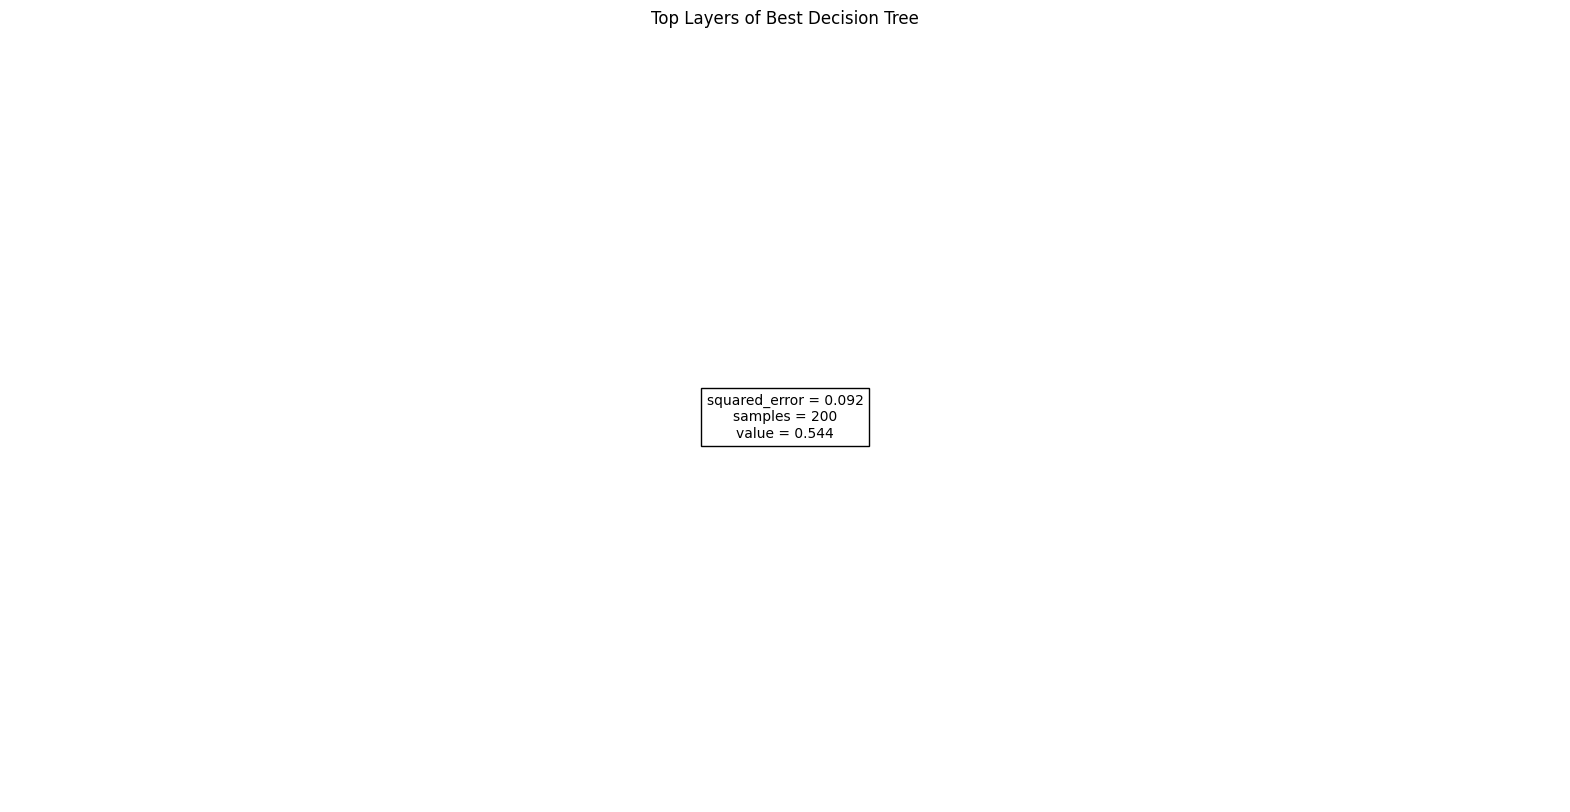

((3, 2, 4, 0.01),
 {'MSE': np.float64(0.15250687669418228),
  'RMSE': np.float64(0.3905212884007507),
  'MAE': np.float64(0.33304663858586736),
  'R2_train': np.float64(0.16560603434852084),
  'R2_test': np.float64(-0.568555730161558),
  'Adj_R2_train': np.float64(0.0166071119107567),
  'Adj_R2_test': np.float64(-0.8486549676904078)})

In [42]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from itertools import product

# Assuming `final_df`, `X1`, and `y` are already defined in the user's session

# Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Define hyperparameter grids
max_depth_values = [3, 5, 10, 20, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]
ccp_alpha_values = [0.0, 0.001, 0.01]

# Setup panel-aware cross-validation
panel_split = PanelSplit(periods=final_df['year'], n_splits=5, gap=0, test_size=1)

results_dt = {}

# Grid search with cross-validation
param_combinations = product(max_depth_values, min_samples_split_values, min_samples_leaf_values, ccp_alpha_values)

for train_idx, test_idx in panel_split.split(X1, y):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for max_depth, min_samples_split, min_samples_leaf, ccp_alpha in param_combinations:
        model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=ccp_alpha,
            random_state=17
        )
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)

        n_train, k = X_train.shape
        n_test = X_test.shape[0]
        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        params_key = (max_depth, min_samples_split, min_samples_leaf, ccp_alpha)
        if params_key not in results_dt:
            results_dt[params_key] = []

        results_dt[params_key].append({
            "MSE": mse_test,
            "RMSE": rmse_test,
            "MAE": mae_test,
            "R2_train": r2_train,
            "R2_test": r2_test,
            "Adj_R2_train": adj_r2_train,
            "Adj_R2_test": adj_r2_test
        })

# Compute average performance
averaged_results_dt = {
    params: {metric: np.mean([fold[metric] for fold in folds])
             for metric in folds[0].keys()}
    for params, folds in results_dt.items()
}

# Find best parameter combination
best_params = min(averaged_results_dt, key=lambda d: averaged_results_dt[d]["MSE"])
best_metrics = averaged_results_dt[best_params]

# Retrain best model on full dataset
best_model = DecisionTreeRegressor(
    max_depth=best_params[0],
    min_samples_split=best_params[1],
    min_samples_leaf=best_params[2],
    ccp_alpha=best_params[3],
    random_state=17
)
best_model.fit(X1, y)

# Print results
print(f"🌳 Best Decision Tree Depth: {best_depth}")
print(f"📊 MSE: {best_metrics['MSE']:.4f}")
print(f"📊 RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")

# Plot top layers of the best tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns, filled=True, max_depth=3, fontsize=10)
plt.title("Top Layers of Best Decision Tree")
plt.show()

# Display final best parameters and metrics
best_params, best_metrics


## Plot

In [52]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Define hyperparameter grid for DecisionTreeRegressor
param_grid = {
    "max_depth": [5, 10, 20, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],
}

# Define the model (no hyperparameters here — GridSearchCV will handle it)
model = DecisionTreeRegressor(random_state=17)


### Setup panel data cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped


# Setup GridSearchCV with PanelSplit cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=panel_split.split(X1, y),  # Custom panel CV
    n_jobs=-1,  # Parallel computation
    verbose=2
)

# Run grid search
grid_search.fit(X1, y)

# Extract best model and hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Store results for best hyperparameters
results = []

# Iterate through each fold for evaluation
for train_idx, test_idx in panel_split.split(X1, y):
    # Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the best model on the current fold
    best_model.fit(X1_train, y_train)

    # Make predictions
    y_train_pred = best_model.predict(X1_train)
    y_test_pred = best_model.predict(X1_test)

    # Compute performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Compute Adjusted R²
    n_train, k = X1_train.shape
    n_test = X1_test.shape[0]
    adj_r2_train = adjusted_r2(r2_train, n_train, k)
    adj_r2_test = adjusted_r2(r2_test, n_test, k)

    # Store results
    results.append({
        "MSE": mse_test,
        "RMSE": rmse_test,
        "MAE": mae_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Adj_R2_train": adj_r2_train,
        "Adj_R2_test": adj_r2_test
    })

# Compute average performance across folds
best_metrics = {metric: np.mean([fold[metric] for fold in results]) for metric in results[0].keys()}

### Print optimal hyperparameters and performance
#print(f"🌲 Best Random Forest Parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
📊 Best MSE: 0.1019
📊 Best RMSE: 0.3177
📊 Best MAE: 0.2645
📊 R² (Train): 0.2640
📊 R² (Test): -0.2713
📊 Adj. R² (Train): 0.2342
📊 Adj. R² (Test): -0.5067


Number of leaves: 9
Tree depth: 5


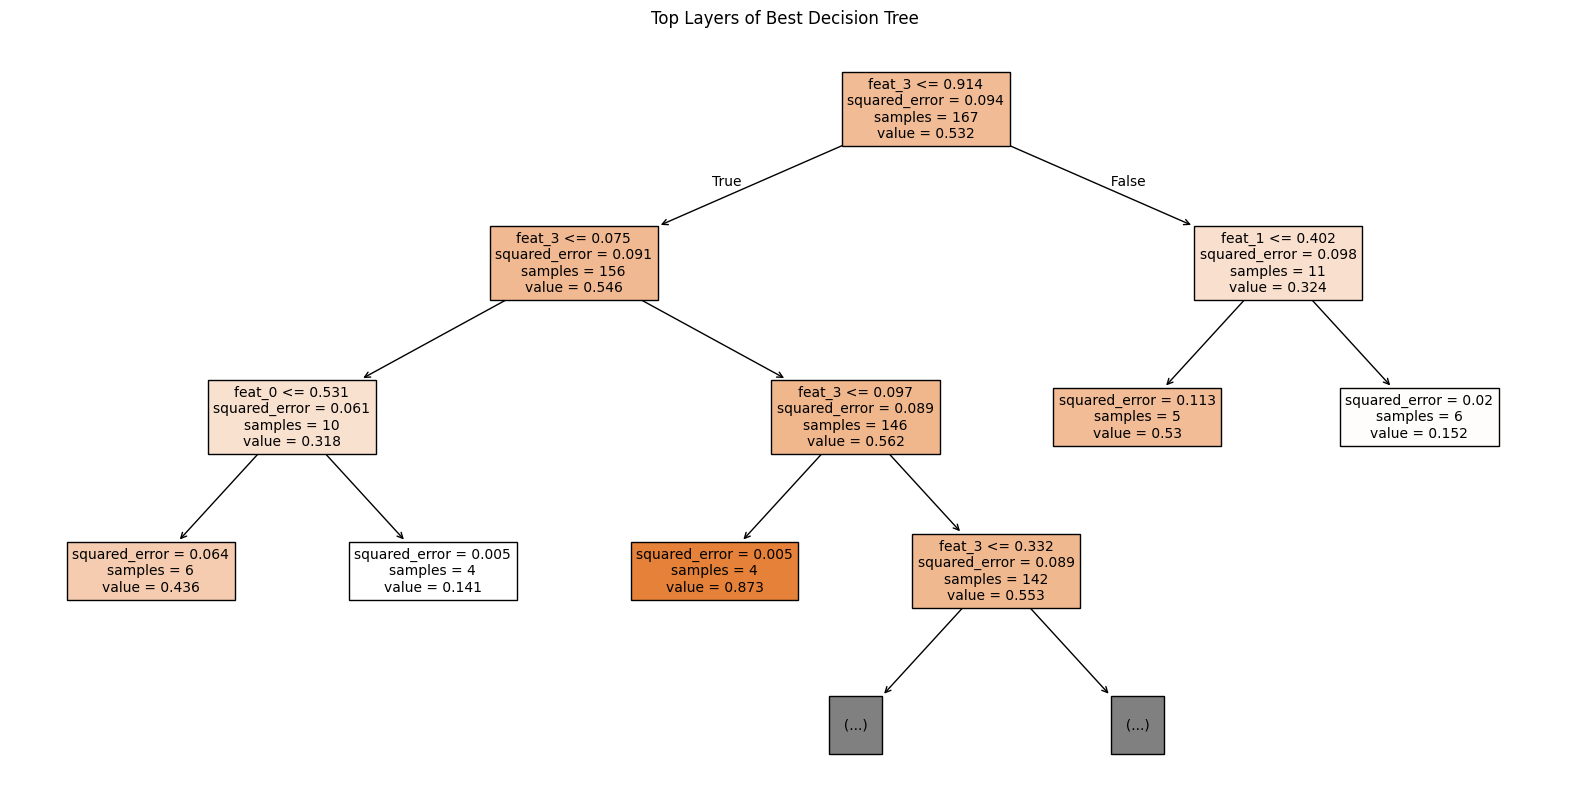

({'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2},
 {'MSE': np.float64(0.10191340626416252),
  'RMSE': np.float64(0.31765361918540386),
  'MAE': np.float64(0.2645215286549562),
  'R2_train': np.float64(0.26402650845876324),
  'R2_test': np.float64(-0.27129029350028827),
  'Adj_R2_train': np.float64(0.23416572176107694),
  'Adj_R2_test': np.float64(-0.5067144219262675)})

In [53]:
np.unique(y_test_pred)

# Print tree structure info
print("Number of leaves:", best_model.get_n_leaves())
print("Tree depth:", best_model.get_depth())

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns, filled=True, max_depth=3, fontsize=10)
plt.title("Top Layers of Best Decision Tree")
plt.show()

# Display final best parameters and metrics
best_params, best_metrics

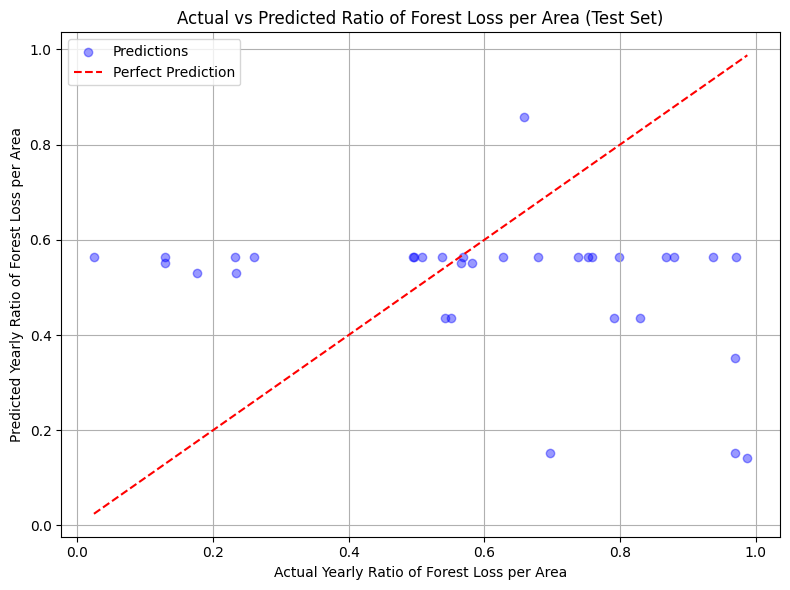

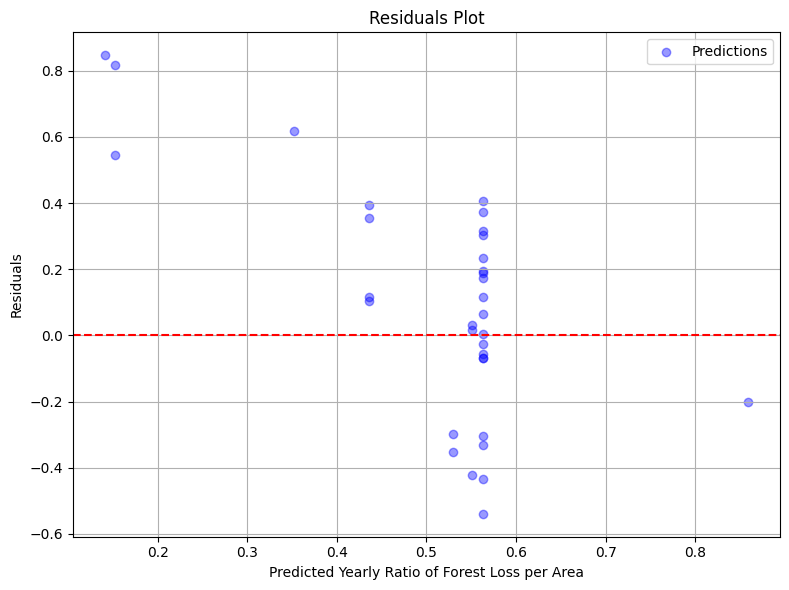

In [47]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Decision tree - mena absolut SHAP values (Top 10 Features)')

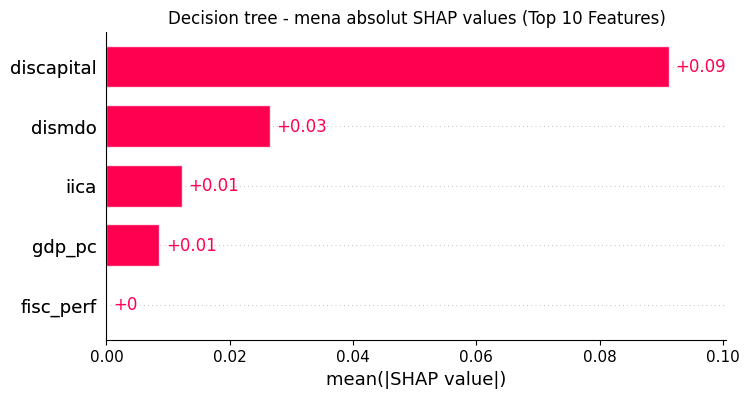

In [49]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X1_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Decision tree - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


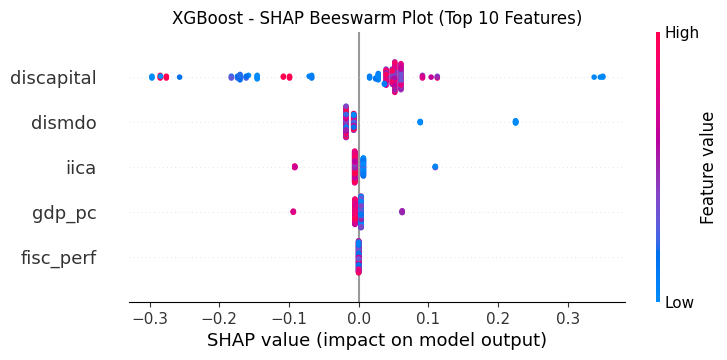

In [50]:
plt.figure(figsize=(16, 10))  
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("XGBoost - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”